In [288]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [289]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\raksh\\anaconda3\\envs\\sop\\Lib\\site-packages\\cv2\\cv2.pyd'
Consider using the `--user` option or check the permissions.



   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.8 MB 1.9 MB/s eta 0:00:21
   ---------------------------------------- 0.0/38.8 MB 1.9 MB/s eta 0:00:21
   ---------------------------------------- 0.1/38.8 MB 465.5 kB/s eta 0:01:24
   ---------------------------------------- 0.1/38.8 MB 717.5 kB/s eta 0:00:54
   ---------------------------------------- 0.2/38.8 MB 756.6 kB/s eta 0:00:52
   ---------------------------------------- 0.2/38.8 MB 748.1 kB/s eta 0:00:52
   ---------------------------------------- 0.2/38.8 MB 692.9 kB/s eta 0:00:56
   ---------------------------------------- 0.2/38.8 MB 625.1 kB/s eta 0:01:02
   ---------------------------------------- 0.2/38.8 MB 625.1 kB/s eta 0:01:02
   ---------------------------------------- 0.3/38.8 MB 700.8 kB/s eta 0:00:55
   ---------------------------------------- 0.4/38.8 MB 716.8 kB/s eta 0:00:54
   ---------------------------------------- 0.4/38.8 MB 750.7 kB/

In [291]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [292]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [293]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [294]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [295]:
# Setup File Paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [296]:
#os.makedirs(POS_PATH)
#os.makedirs(NEG_PATH)
#os.makedirs(ANC_PATH)

In [297]:
# Uncompress labelled faces in the tar dataset
#!tar -xf lfw.tgz

In [298]:
# Move lfw to the data/negative folder
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        CUR_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(CUR_PATH, NEW_PATH)

In [299]:
# Generate random unique image names
import uuid

In [300]:
#os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

In [301]:
# Camera Availability

cam_avail = []

for camera in range(10):
    cap = cv2.VideoCapture(camera)
    if cap.isOpened():
        print("Cameras available:", camera)
        cam_avail.append(camera)
        cap.release()
print(cam_avail)

Cameras available: 0
[0]


In [179]:
# Establishing Connection to WebCam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    # Cut down frame to 250x250px
    frame = frame[120:120+250, 200:200+250]

    # Collecting Anchor
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Save the anchor image
        cv2.imwrite(imgname, frame)

    cv2.imshow("Image Collected", frame)

    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

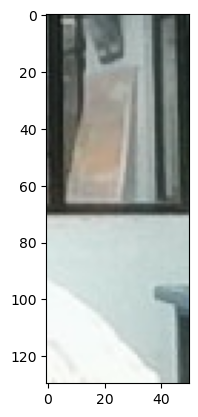

In [302]:
plt.imshow(frame[120:120+250, 200:200+250, :])

In [16]:
# Collecting Positive Images
import time
number_images = 6

cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print("Collecting image {}".format(imgnum))
    ret, frame = cap.read()
    # Tempo
    frame = frame[120:120+250, 200:200+250, :]

    imgname = os.path.join(POS_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('6 Images',frame)
    time.sleep(5)

    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [303]:
# Create a Dataset of each type of image
anchor = tf.data.Dataset.list_files(ANC_PATH + '\*.jpg').take(6)
positive = tf.data.Dataset.list_files(POS_PATH + '\*.jpg').take(6)
negative = tf.data.Dataset.list_files(NEG_PATH + '\*.jpg').take(6)

In [304]:
dir_test = anchor.as_numpy_iterator()

In [183]:
print(dir_test.next())

b'data\\anchor\\bc802877-1e72-11ef-a55b-141333b9f77e.jpg'


# Preprocess - Scale and Resizing Image

In [305]:
def preprocess(file_path):

    # Read image from the file path
    byte_img = tf.io.read_file(file_path)
    # Decode byte string to Array
    img = tf.io.decode_jpeg(byte_img)

    # Resize the image to be 100x100
    img = tf.image.resize(img, (100, 100))

    img = img/255.0
    return img

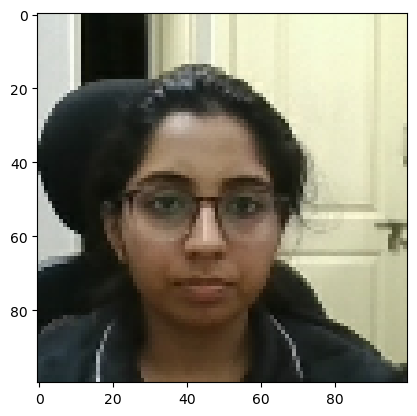

In [306]:
img = preprocess('data\\anchor\\bc802877-1e72-11ef-a55b-141333b9f77e.jpg')
plt.imshow(img)

# Create Labelled Dataset

In [307]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))

# Combine the positive and negative Datasets into One
data = positives.concatenate(negatives)


In [308]:
data

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [309]:
samples = data.as_numpy_iterator()

In [316]:
ex = samples.next()
ex

(b'data\\anchor\\bc802877-1e72-11ef-a55b-141333b9f77e.jpg',
 b'data\\negative\\Yoriko_Kawaguchi_0008.jpg',
 0.0)

# Build, Train & Test

In [317]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [318]:
res = preprocess_twin(*ex)

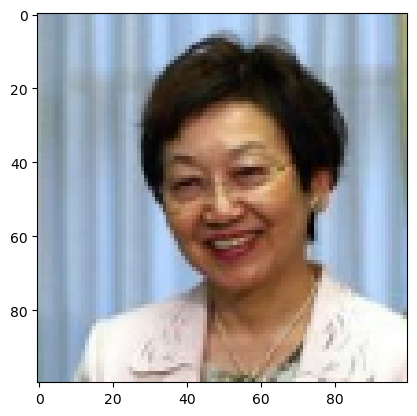

In [319]:
plt.imshow(res[1])
# res[0] - Shows the anchor image
# res[1] - Shows the positive/negative image dependent on the 'ex' value
# res[2] - Shows the Labelled Value for the 2 datasets
# Label value is '1' - For 'anchor' and 'positive' image
# Label value is '0' - For 'anchor' and 'negative' image

In [320]:
res[2]

0.0

In [321]:
# Build DataLoader Pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [322]:
# Training Part

# 70% of the data is taken first
train_data = data.take(round(len(data)*0.7))

# Now the data will be sent in a batch of 16
train_data = train_data.batch(16)

# Starts preprocessing the next set of images so that we don't bottleup our neural network
train_data = train_data.prefetch(8)

In [323]:
# Refine/ Testing Phase
test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Embedding Layers

In [324]:
inp = Input(shape=(100,100,3), name="input_img")

In [325]:
cl1 = Conv2D(64, (10,10), activation='relu')(inp)

In [326]:
cl1

<KerasTensor: shape=(None, 91, 91, 64) dtype=float32 (created by layer 'conv2d_16')>

In [327]:
m1 = MaxPooling2D(64, (2,2), padding='same')(cl1)

In [328]:
m1

<KerasTensor: shape=(None, 46, 46, 64) dtype=float32 (created by layer 'max_pooling2d_12')>

In [329]:
cl2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(cl2)

print(cl2)
print(m2)

KerasTensor(type_spec=TensorSpec(shape=(None, 40, 40, 128), dtype=tf.float32, name=None), name='conv2d_17/Relu:0', description="created by layer 'conv2d_17'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20, 20, 128), dtype=tf.float32, name=None), name='max_pooling2d_13/MaxPool:0', description="created by layer 'max_pooling2d_13'")


In [330]:
cl3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(cl3)

print(cl3)
print(m3)

KerasTensor(type_spec=TensorSpec(shape=(None, 17, 17, 128), dtype=tf.float32, name=None), name='conv2d_18/Relu:0', description="created by layer 'conv2d_18'")
KerasTensor(type_spec=TensorSpec(shape=(None, 9, 9, 128), dtype=tf.float32, name=None), name='max_pooling2d_14/MaxPool:0', description="created by layer 'max_pooling2d_14'")


In [331]:
cl4 = Conv2D(256, (4,4), activation='relu')(m3)

# flattning all the output of CNN layer which are in 3D into a single Dimension
f1 = Flatten()(cl4)
d1 = Dense(4096, activation='sigmoid')(f1)

print(cl4)
print(f1)
print(d1)

KerasTensor(type_spec=TensorSpec(shape=(None, 6, 6, 256), dtype=tf.float32, name=None), name='conv2d_19/Relu:0', description="created by layer 'conv2d_19'")
KerasTensor(type_spec=TensorSpec(shape=(None, 9216), dtype=tf.float32, name=None), name='flatten_4/Reshape:0', description="created by layer 'flatten_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4096), dtype=tf.float32, name=None), name='dense_8/Sigmoid:0', description="created by layer 'dense_8'")


In [332]:
mod = Model(inputs=[inp], outputs=[d1], name="Embedding")

In [333]:
mod.summary()

Model: "Embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_img (InputLayer)      [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 46, 46, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 17, 17, 128)       26

In [334]:
def make_embedding():

    # First Layer
    inp = Input(shape=(100,100,3), name="input_img")
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second Layer
    cl2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(cl2)

    # Third Layer
    cl3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(cl3)

    # Fourth Layer 
    cl4 = Conv2D(256, (4,4), activation='relu')(m3)

    # flattning all the output of CNN layer which are in 3D into a single Dimension
    f1 = Flatten()(cl4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=[inp], outputs=[d1], name="Embedding")

In [335]:
em = make_embedding()
em.summary()

Model: "Embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_img (InputLayer)      [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_20 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 46, 46, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 17, 17, 128)       26

In [336]:
type(em)

keras.engine.functional.Functional

# Building Distance Layer

In [337]:
class L1Dist(Layer):

    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

# Subtracting cause we want to determine the similarity between them

In [338]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100, 100, 3))

In [339]:
em(input_image)

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'Embedding')>

In [340]:
inp_embedding = em(input_image)
val_embedding = em(validation_image)

In [341]:
print(type(inp_embedding))

<class 'keras.engine.keras_tensor.KerasTensor'>


In [342]:
siamese_layer = L1Dist()

In [343]:
distances = siamese_layer(inp_embedding, val_embedding)

In [344]:
type(distances)

keras.engine.keras_tensor.KerasTensor

In [345]:
classifier = Dense(1, activation='sigmoid')(distances)

In [346]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 Embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [347]:
def make_siamese_model():

    # Anchor image as input
    input_image = Input(name='input_img', shape=(100, 100, 3))

    # Validation image - Positive/Negative
    validation_image = Input(name='validation_img', shape=(100, 100, 3))

    # Combining all components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(em(input_image), em(validation_image))

    # Classification Layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [348]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 Embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Training of Model

In [349]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [350]:
opt = tf.keras.optimizers.Adam(1e-4)

**Establish checkpoints**

In [351]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model = siamese_model)

In [352]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()

In [353]:
batch_1

(array([[[[0.59313726, 0.56960785, 0.42843136],
          [0.5872549 , 0.5637255 , 0.422549  ],
          [0.595098  , 0.5715686 , 0.43039215],
          ...,
          [0.5470588 , 0.5245098 , 0.3990196 ],
          [0.5372549 , 0.5235294 , 0.39509803],
          [0.5254902 , 0.5254902 , 0.39215687]],
 
         [[0.5884804 , 0.564951  , 0.4237745 ],
          [0.5889706 , 0.5654412 , 0.4242647 ],
          [0.5882353 , 0.5647059 , 0.42352942],
          ...,
          [0.5480392 , 0.52843136, 0.40294117],
          [0.5372549 , 0.5235294 , 0.39362746],
          [0.52843136, 0.5254902 , 0.3852941 ]],
 
         [[0.59387255, 0.57034314, 0.42916667],
          [0.5990196 , 0.5754902 , 0.4343137 ],
          [0.5921569 , 0.5686275 , 0.42745098],
          ...,
          [0.5480392 , 0.53137255, 0.3970588 ],
          [0.54044116, 0.527451  , 0.39093137],
          [0.5394608 , 0.5276961 , 0.39044118]],
 
         ...,
 
         [[0.8181372 , 0.8338235 , 0.8377451 ],
          [0.79142

In [354]:
X = batch_1[:2]

In [355]:
Y = batch_1[2]

**Build Train Function**

In [356]:
@tf.function
def train_step(batch):

    with tf.GradientTape() as tape:

        # Anchor & Pos/Neg Image
        X = batch[:2]

        # Get Label
        Y = batch[2]

        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(Y, yhat)
    print(loss)

    # Calculate gradients 
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

**Building a Training Loop**

In [357]:
def train(data, EPOCHS):

    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data)) # Shows Progress Bar

        # Loop through each Batch
        for idx, batch in enumerate(data):
            # Do training step here
            train_step(batch)
            progbar.update(idx+1)

        # Save Checkpoint
        if epoch % 10 ==0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [358]:
EPOCHS = 50

In [359]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
1/1 [==============================] - 3s 3s/step

 Epoch 2/50
1/1 [==============================] - 2s 2s/step

 Epoch 3/50
1/1 [==============================] - 2s 2s/step

 Epoch 4/50
1/1 [==============================] - 2s 2s/step

 Epoch 5/50
1/1 [==============================] - 1s 1s/step

 Epoch 6/50
1/1 [==============================] - 1s 1s/step

 Epoch 7/50
1/1 [==============================] - 1s 1s/step

 Epoch 8/50
1/1 [==============================] - 1s 1s/step

 Epoch 9/50
1/1 [==============================] - 2s 2s/step

 Epoch 10/50
1/1 [==============================] - 2s 2s/step

 Epoch 11/50
1/1 [==============================] - 1s 1s/step

 Epoch 12/50
1/1 [==============================] - 2s 2s/step

 Epoch 13/50
1/1 [==============================] - 2s 2s/step

 Epoch 14/50
1/1 [====

#Evaluate Model and Make Prediction

In [363]:
from tensorflow.keras.metrics import Precision,Recall

In [364]:
test_input,test_val,y_true=test_data.as_numpy_iterator().next()

In [365]:
len(test_val)

4

In [366]:
#test_var=test_data.as_numpy_iterator().next()

In [367]:
y_true

array([1., 0., 1., 0.], dtype=float32)

In [368]:
test_var = test_data.as_numpy_iterator().next()

In [369]:
len(test_var)

3

In [370]:
#Make predictions
y_hat=siamese_model.predict([test_input,test_val])
y_hat

1/1 [==============================] - 1s 537ms/step


array([[0.6232212 ],
       [0.00294455],
       [0.9831319 ],
       [0.00297323]], dtype=float32)

In [371]:
res=[]
for prediction in y_hat:
    if prediction>0.5:
        res.append(1)
    else:
        res.append(0)
res

[1, 0, 1, 0]

In [372]:
y_true

array([1., 0., 1., 0.], dtype=float32)

Calculating Metrics

In [373]:
#Create a metric object
m=Recall()

#Calculating the recall value
m.update_state(test_var[2],y_hat)

#Return the Recall Result
m.result().numpy()

0.0

In [374]:
#Create a metric object
m=Precision()

#Calculating the value
m.update_state(test_var[2],y_hat)

#Return the Recall Result
m.result().numpy()

0.0

Visualize

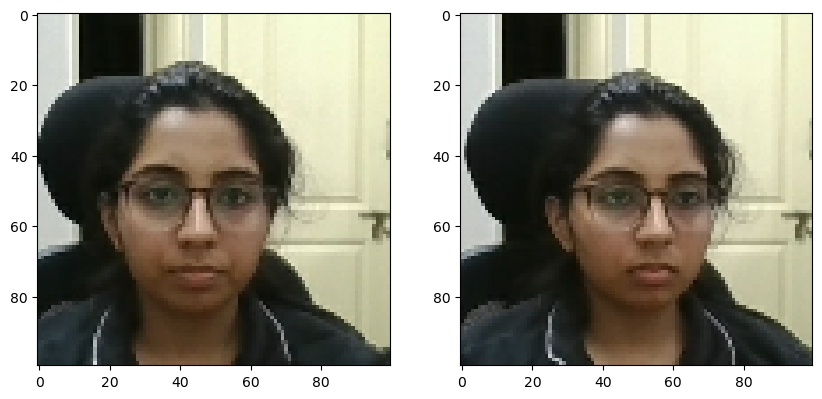

In [375]:
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.imshow(test_input[0])

plt.subplot(1,2,2)
plt.imshow(test_val[0])

plt.show()

#Save the Model

In [376]:
siamese_model.save('siamesemodel.h5')

In [377]:
#Reload model
model=tf.keras.models.load_model('siamesemodel.h5',custom_objects={'L1Dist':L1Dist,'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [378]:
model.predict([test_input,test_val])

1/1 [==============================] - 0s 461ms/step


array([[0.622872  ],
       [0.00294449],
       [0.9810099 ],
       [0.0040106 ]], dtype=float32)

In [379]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 Embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

Real Time Verification

Detection Threshold-The first time the minimum probability for verification is achieved
Verification Threshold-After detection,the final step for verification which involves calculation of verified_input/verification_images

In [380]:
import shutil
import glob
import os

IMAGES_PATH=os.path.join('data','positive')

VER_PATH=os.path.join('application_data','verification_images')

for i in os.listdir(IMAGES_PATH):
    print(i)

a600d817-1c37-11ef-81ad-141333b9f77e.jpg
a9058293-1c37-11ef-afbf-141333b9f77e.jpg
ac016e07-1c37-11ef-869a-141333b9f77e.jpg
aefee663-1c37-11ef-b1e0-141333b9f77e.jpg
b1fd4a94-1c37-11ef-a008-141333b9f77e.jpg
b4fc0863-1c37-11ef-adbe-141333b9f77e.jpg


In [381]:
for jpgfile in glob.iglob(os.path.join(IMAGES_PATH,"*.jpg")):
    shutil.copy(jpgfile,VER_PATH)

for image in od.listdir(VER_PATH):
    print(image)

FileNotFoundError: [Errno 2] No such file or directory: 'application_data\\verification_images'

In [285]:
#Captured image from webcam will be stored in this folder
os.path.join('application_data','input_image','input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [286]:
def verify(model,detection_threshold,verification_threshold):
    results=[]
    for image in os.listdir(os.path.join('application_data','verification_images')):
        input_image=preprocess(os.path.join('application_data','input_image','input_image.jpg'))
        validation_img=preprocess(os.path.join('application_data',verification_images',image))

        #Make predictions
        result=model.predict(list(np.expand_dims([input_image,validation_image],axis=1)))
        result.append(result)
    detection=np.sum(np.array(results)>detection_threshold)
    #Calculations for final verification
    verification=detection/len(os.listdir(os.path.join('application_data','verification_images')))
                
     return results,verified
    #Detection Threshold:Metric above which a prediction is considered true
     #Verification Threshold:Calculation of positive_predictions/total positive samples   

SyntaxError: EOL while scanning string literal (3914200402.py, line 5)

In [ ]:
#webcam verification

cap=cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame=cap.read()
    frame_roi=frame[120:120+250,200:200+250]

    cv2.imshow('Verification',frame_roi)

    #Verification Trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application_data','input_image','input_image.jpg'),frame_roi
        #

